In [1]:
!pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
from ortools.sat.python import cp_model


def build_model(base_rate_1, base_rate_2, epsilon_size, min_ppv=0.0, max_ppv=1.0, min_fnr=0.0, max_fnr=1.0, min_fpr=0.0, max_fpr=1.0, num_vals=10):
    # make sure parameters are integers, otherwise a larger num_vals is needed
    assert(float.is_integer(base_rate_1 * num_vals))
    assert(float.is_integer(base_rate_2 * num_vals))
    assert(float.is_integer(epsilon_size * num_vals))
    assert(float.is_integer(min_ppv * num_vals))
    assert(float.is_integer(max_ppv * num_vals))
    assert(float.is_integer(min_fnr * num_vals))
    assert(float.is_integer(max_fnr * num_vals))
    assert(float.is_integer(min_fpr * num_vals))
    assert(float.is_integer(max_fpr * num_vals))

    # instantiate model
    model = cp_model.CpModel()

    # create primary decision variables.
    min_val = -num_vals
    max_val = num_vals

    min_ppv_val = round(min_ppv * num_vals)
    max_ppv_val = round(max_ppv * num_vals)

    min_beta_val = round(min_fnr * num_vals)
    max_beta_val = round(max_fnr * num_vals)

    min_alpha_val = round(min_fpr * num_vals)
    max_alpha_val = round(max_fpr * num_vals)

    alpha_1 = model.NewIntVar(min_alpha_val, max_alpha_val, 'alpha_1')
    beta_1 = model.NewIntVar(min_beta_val, max_beta_val, 'beta_1')
    p_1 = model.NewIntVar(0, max_val, 'p_1')
    v_1 = model.NewIntVar(min_ppv_val, max_ppv_val, 'v_1') 

    alpha_2 = model.NewIntVar(min_alpha_val, max_alpha_val, 'alpha_2')
    beta_2 = model.NewIntVar(min_beta_val, max_beta_val, 'beta_2')
    p_2 = model.NewIntVar(0, max_val, 'p_2')
    v_2 = model.NewIntVar(min_ppv_val, max_ppv_val, 'v_2')  

    e_alpha = model.NewIntVar(min_val, max_val, 'e_alpha')
    e_beta = model.NewIntVar(min_val, max_val, 'e_beta')
    e_p = model.NewIntVar(min_val, max_val, 'e_p')
    e_v = model.NewIntVar(min_val, max_val, 'e_v')  

    # set e_p and p
    p_1_val = round(base_rate_1 * num_vals)
    p_2_val = round(base_rate_2 * num_vals)
    model.Add(p_1 == p_1_val)
    model.Add(p_2 == p_2_val)

    # metric_1 = metric_2 + e_metric
    model.Add(alpha_1 == alpha_2 + e_alpha)
    model.Add(beta_1 == beta_2 + e_beta)
    model.Add(v_1 == v_2 + e_v)
    model.Add(p_1 == p_2 + e_p)

    # |epsilon_i| <= epsilon_size 
    # TODO: compare this to bounds when defining the variables
    min_epsilon = round(-epsilon_size * num_vals)
    max_epsilon = round(epsilon_size * num_vals)
    model.AddLinearConstraint(linear_expr=e_alpha, lb=min_epsilon, ub=max_epsilon)
    model.AddLinearConstraint(linear_expr=e_beta, lb=min_epsilon, ub=max_epsilon)
    model.AddLinearConstraint(linear_expr=e_v, lb=min_epsilon, ub=max_epsilon)

    # alpha = (p / (1 - p)) * (1 - v) / v * (1 - beta) all scalled by num_vals
    # NOTE: requires intermediate variables
    min_val = 0
    max_val_2 = num_vals**2
    max_val_3 = num_vals**3

    numerator_partial_1 = model.NewIntVar(min_val, max_val_2, 'numerator_partial_1')
    numerator_1 = model.NewIntVar(min_val, max_val_3, 'numerator_1')
    denominator_1 = model.NewIntVar(1, max_val_2, 'denominator_1')
    model.AddMultiplicationEquality(numerator_partial_1, [p_1, (num_vals - v_1)])
    model.AddMultiplicationEquality(numerator_1, [numerator_partial_1, (num_vals - beta_1)])
    model.AddMultiplicationEquality(denominator_1, [v_1, (num_vals - p_1)])
    # model.AddDivisionEquality(target=alpha_1, num=numerator_1, denom=denominator_1)
    model.AddMultiplicationEquality(numerator_1, [alpha_1, denominator_1])

    numerator_partial_2 = model.NewIntVar(min_val, max_val_2, 'numerator_partial_2')
    numerator_2 = model.NewIntVar(min_val, max_val_3, 'numerator_2')
    denominator_2 = model.NewIntVar(1, max_val_2, 'denominator_2')
    model.AddMultiplicationEquality(numerator_partial_2, [p_2, (num_vals - v_2)])
    model.AddMultiplicationEquality(numerator_2, [numerator_partial_2, (num_vals - beta_2)])
    model.AddMultiplicationEquality(denominator_2, [v_2, (num_vals - p_2)])
    # model.AddDivisionEquality(target=alpha_2, num=numerator_2, denom=denominator_2)
    model.AddMultiplicationEquality(numerator_2, [alpha_2, denominator_2])

    # store variables for solution_printer
    variables = [p_1, p_2, alpha_1, alpha_2, beta_1, beta_2, v_1, v_2]
    
    return(model, variables)


class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """ Print print all feasible solutions.
        adapted from https://developers.google.com/optimization/cp/cp_solverz
    """

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0
        self.__solution_list = []

    def on_solution_callback(self):
        self.__solution_count += 1
        current_solution_dict = {}
        for v in self.__variables:
            current_solution_dict[str(v)] = self.Value(v)
        self.__solution_list.append(current_solution_dict)

    def solution_count(self):
        return self.__solution_count
    
    def solution_df(self):
        return pd.DataFrame(self.__solution_list)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

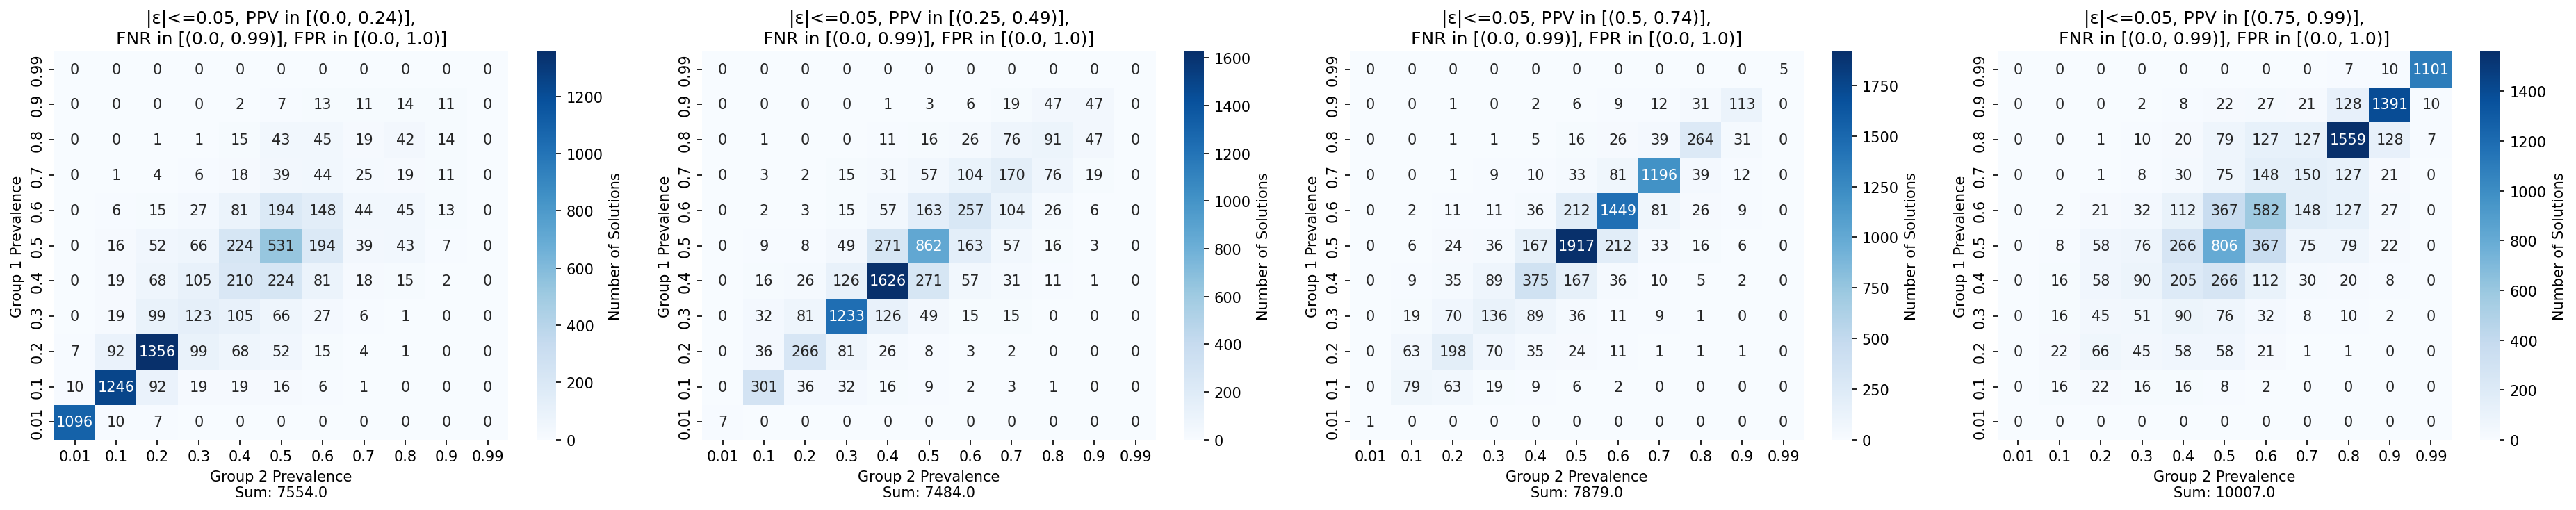

In [3]:
results_df_columns = ['p1','p2','epsilon','num_solutions', 'ppv_window']
results_df = pd.DataFrame()

base_rates = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
ppv_ranges = [(0.0, 0.24), (0.25, 0.49), (0.50, 0.74), (0.75, 0.99)]
fnr_ranges = [(0.0, 0.99)] * len(ppv_ranges)
fpr_ranges = [(0.0, 1.0)] * len(ppv_ranges)
integer_values = [100] * len(ppv_ranges)
epsilon_sizes = [0.05] * len(ppv_ranges)
fig, axes = plt.subplots(nrows=1, ncols=len(epsilon_sizes), figsize=(25, 5), dpi=150)
axes = axes.ravel()
for i, ((min_ppv, max_ppv), (min_fnr, max_fnr), (min_fpr, max_fpr), num_vals, epsilon_size) in enumerate(tqdm(list(zip(ppv_ranges, fnr_ranges, fpr_ranges, integer_values, epsilon_sizes)))):
    for base_rate_1 in tqdm(base_rates):
        for base_rate_2 in base_rates:

            # build cp model
            model, variables = build_model(base_rate_1=base_rate_1, base_rate_2=base_rate_2, epsilon_size=epsilon_size, min_ppv=min_ppv, max_ppv=max_ppv, min_fnr=min_fnr, max_fnr=max_fnr, min_fpr=min_fpr, max_fpr=max_fpr, num_vals=num_vals)
            solution_printer = VarArraySolutionPrinter(variables)

            # initialize solver
            solver = cp_model.CpSolver()

            # enumerate all solutions
            solver.parameters.enumerate_all_solutions = True
            status = solver.Solve(model, solution_printer)

            # save num solutions
            num_solutions = solution_printer.solution_count()

            r = {'p1': base_rate_1,
                 'p2': base_rate_2,
                 'epsilon': epsilon_size,
                 'ppv_window': (min_ppv, max_ppv),
                 'num_solutions': num_solutions}
            results_df = results_df.append(r, ignore_index=True)

    results_pivot_df = results_df[results_df['ppv_window'] == (min_ppv, max_ppv)].pivot('p1', 'p2', 'num_solutions')
    sns.heatmap(results_pivot_df, annot=True, ax=axes[i], fmt='g', vmin=0, cbar_kws={'label': 'Number of Solutions'}, cmap='Blues')
    axes[i].invert_yaxis()
    plot_title = f'|ε|<={epsilon_size}, PPV in [{min_ppv, max_ppv}],\nFNR in [{min_fnr, max_fnr}], FPR in [{min_fpr, max_fpr}]'
    axes[i].set_title(plot_title)
    sum_of_cells = results_pivot_df.sum().sum()
    axes[i].set_xlabel(f'Group 2 Prevalence\nSum: {sum_of_cells}')
    axes[i].set_ylabel('Group 1 Prevalence')
plt.tight_layout()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

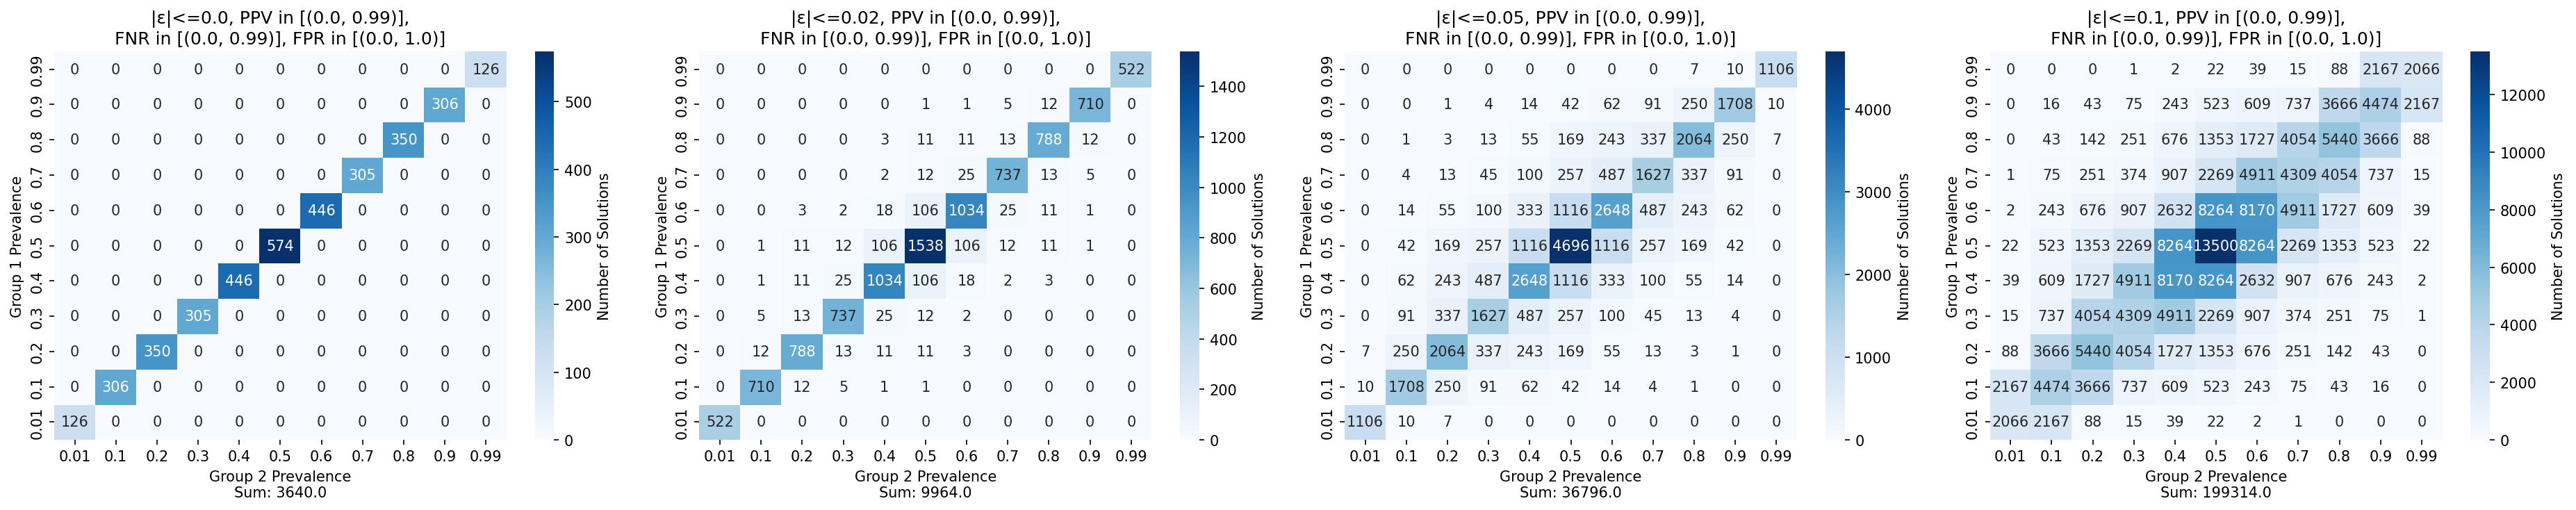

In [4]:
results_df_columns = ['p1','p2','epsilon','num_solutions', 'ppv_window']
results_df = pd.DataFrame()

base_rates = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
epsilon_sizes = [0.0, 0.02, 0.05, 0.1]
ppv_ranges = [(0.0, 0.99)] * len(epsilon_sizes)
fnr_ranges = [(0.0, 0.99)] * len(epsilon_sizes)
fpr_ranges = [(0.0, 1.0)] * len(epsilon_sizes)
integer_values = [100] * len(epsilon_sizes)
fig, axes = plt.subplots(nrows=1, ncols=len(epsilon_sizes), figsize=(25, 5), dpi=150)
axes = axes.ravel()
for i, ((min_ppv, max_ppv), (min_fnr, max_fnr), (min_fpr, max_fpr), num_vals, epsilon_size) in enumerate(tqdm(list(zip(ppv_ranges, fnr_ranges, fpr_ranges, integer_values, epsilon_sizes)))):
    for base_rate_1 in tqdm(base_rates):
        for base_rate_2 in base_rates:

            # build cp model
            model, variables = build_model(base_rate_1=base_rate_1, base_rate_2=base_rate_2, epsilon_size=epsilon_size, min_ppv=min_ppv, max_ppv=max_ppv, min_fnr=min_fnr, max_fnr=max_fnr, min_fpr=min_fpr, max_fpr=max_fpr, num_vals=num_vals)
            solution_printer = VarArraySolutionPrinter(variables)

            # initialize solver
            solver = cp_model.CpSolver()

            # enumerate all solutions
            solver.parameters.enumerate_all_solutions = True
            status = solver.Solve(model, solution_printer)

            # save num solutions
            num_solutions = solution_printer.solution_count()

            r = {'p1': base_rate_1,
                 'p2': base_rate_2,
                 'epsilon': epsilon_size,
                 'ppv_window': (min_ppv, max_ppv),
                 'num_solutions': num_solutions}
            results_df = results_df.append(r, ignore_index=True)

    # plt.figure(figsize=(8, 6), dpi=150)
    results_pivot_df = results_df[results_df['epsilon'] == epsilon_size].pivot('p1', 'p2', 'num_solutions')
    sns.heatmap(results_pivot_df, annot=True, ax=axes[i], fmt='g', vmin=0, cbar_kws={'label': 'Number of Solutions'}, cmap='Blues')
    axes[i].invert_yaxis()
    plot_title = f'|ε|<={epsilon_size}, PPV in [{min_ppv, max_ppv}],\nFNR in [{min_fnr, max_fnr}], FPR in [{min_fpr, max_fpr}]'
    axes[i].set_title(plot_title)
    sum_of_cells = results_pivot_df.sum().sum()
    axes[i].set_xlabel(f'Group 2 Prevalence\nSum: {sum_of_cells}')
    axes[i].set_ylabel('Group 1 Prevalence')
plt.tight_layout()
plt.show()